## Experiment #1: NAS using NSGA-II on NATS-BENCH Topology search space(TSS)

In this experiment, we will use NSGA-II algorithm to search for neural architectures in the NATS-BENCH TSS dataset.

- Each neural network will be encoded by a list of 6 int number, each number represent an operation in a set of five operations:

    -`_OPERATIONS = ["none", "skip_connect", "nor_conv_1x1", "nor_conv_3x3", "avg_pool_3x3"]`
    
    For example, a neural network encoded by: [4, 4, 4, 4, 4, 4] would means all of the operations are avg_pool_3x3
    
    each operation represents an edge in a complete DAG of 4 nodes.
- The NSGA-II will use 1 point crossover, np.random.randint(0, 5, 1) mutation for each gene.

- We will search on 3 datasets: CIFAR10, CIFAR100, Imagenet16-120. For each dataset, we will compare the pareto optimal searched by the NSGA-II algorithm, random search algorithm and the true pareto optimal on 2 objective: val-error and FLOPs. We then compare them on test dataset.
 
 **The question we are trying to anwser in this notebook is: If we can only evaluate n networks, will the NSGA-II algorithm using the described encoding scheme performs better than random search?**
 
 ##### Checked questions:
 - the encode and decode process from gennome to api network structure is checked and valid.

In [1]:
# !pip install pymoo
# !pip install nats_bench
# !pip install tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation

from tqdm.notebook import tqdm
import pprint
import core.nats_api as nats_api


In [2]:
natsapi = nats_api.NATSAPI('/home/azureuser/cloudfiles/code/Users/hao/NATS-tss-v1_0-3ffb9-simple')

### First let's find the optimal pareto of the search space on 3 datasets

In [ ]:
#ImageNet16-120
# There are some random in the results returned by this api called, since each network was trained for 3 times, and the result
# is randomly chosen among those trained networks

all_networks = {}

for i in tqdm(range(len(natsapi))):
    all_networks[i] = {}
    all_networks[i]['cifar10'] = natsapi.query_performance(genome = i, dataset = 'cifar10')
    all_networks[i]['cifar100'] = natsapi.query_performance(genome = i, dataset = 'cifar100')
    all_networks[i]['ImageNet16-120'] = natsapi.query_performance(genome = i, dataset = 'ImageNet16-120')
    

In [3]:
# save the all_networks dict into a json file
# with open("all_networks.json", 'w') as f:
#     json.dump(all_networks, f, sort_keys = True, indent = 4)
    
# load the json data
with open("all_networks.json", 'r') as f:
    loaded_networks = json.load(f)
    

In [4]:
print(len(loaded_networks))
print(loaded_networks['0'])

15625
{'ImageNet16-120': {'FLOPs': 3.91948, 'test-accuracy': 27.033333257039388, 'valid-accuracy': 28.333333353678384}, 'cifar10': {'FLOPs': 15.64737, 'test-accuracy': 85.62}, 'cifar100': {'FLOPs': 15.65322, 'test-accuracy': 53.67999995727539, 'valid-accuracy': 53.07999993286133}}


### Let's define a function to find the pareto optimal, using it to find and plot the optimal pareto fronts of 3 datasets.

In [27]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

In [30]:
cf10_err = []
cf10_FLOPs = []

cf100_err = []
cf100_FLOPs = []

imn_err = []
imn_FLOPs = []

for i in tqdm(range(len(loaded_networks))):
    cf10_err.append(100 - loaded_networks[str(i)]['cifar10']['test-accuracy'])
    cf10_FLOPs.append(loaded_networks[str(i)]['cifar10']['FLOPs'])
    
    cf100_err.append(100 - loaded_networks[str(i)]['cifar100']['valid-accuracy'])
    cf100_FLOPs.append(loaded_networks[str(i)]['cifar100']['FLOPs'])
    
    imn_err.append(100 - loaded_networks[str(i)]['ImageNet16-120']['valid-accuracy'])
    imn_FLOPs.append(loaded_networks[str(i)]['ImageNet16-120']['FLOPs'])
    

  0%|          | 0/15625 [00:00<?, ?it/s]

In [31]:
# create the objective arrays
NUM_NETWORKS = 15625
cf10_objs = np.hstack((np.array(cf10_err).reshape(NUM_NETWORKS, 1), np.array(cf10_FLOPs).reshape(NUM_NETWORKS, 1)))
cf100_objs = np.hstack((np.array(cf100_err).reshape(NUM_NETWORKS, 1), np.array(cf100_FLOPs).reshape(NUM_NETWORKS, 1)))
imn_objs = np.hstack((np.array(imn_err).reshape(NUM_NETWORKS, 1), np.array(imn_FLOPs).reshape(NUM_NETWORKS, 1)))

# now we'll find the optimal pareto front
cf10_pareto = is_pareto_efficient_simple(cf10_objs)
cf100_pareto = is_pareto_efficient_simple(cf100_objs)
imn_pareto = is_pareto_efficient_simple(imn_objs)

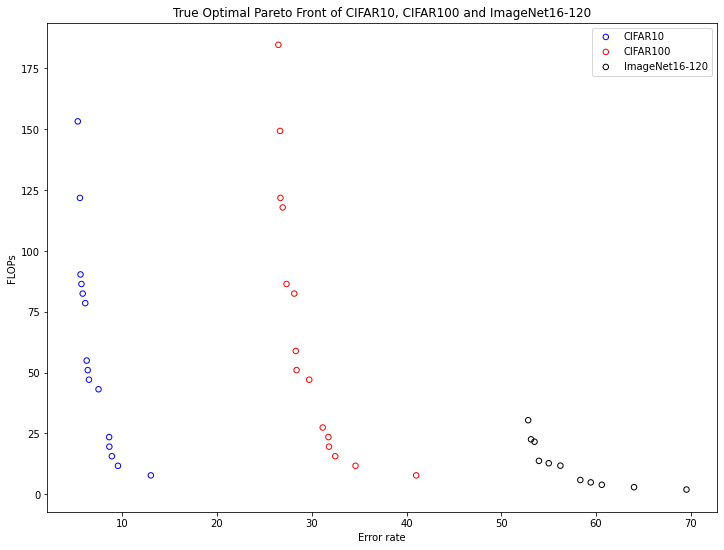

In [32]:
# Now let's plot all of them together

plt.figure(figsize=(12, 9))
plt.scatter(cf10_objs[cf10_pareto][:, 0],cf10_objs[cf10_pareto][:, 1], s=30, facecolors='none', edgecolors='blue', label = 'CIFAR10')
plt.scatter(cf100_objs[cf100_pareto][:,0],cf100_objs[cf100_pareto][:,1] , s=30, facecolors='none', edgecolors='red', label = 'CIFAR100')
plt.scatter(imn_objs[imn_pareto][:, 0], imn_objs[imn_pareto][:,1], s=30, facecolors='none', edgecolors='black', label = 'ImageNet16-120')

plt.title("True Optimal Pareto Front of CIFAR10, CIFAR100 and ImageNet16-120")
plt.xlabel("Error rate")
plt.ylabel("FLOPs")
plt.legend()
plt.show()

### NSGA-II and random search

**Now we'll use NSGA-II algorithm and random search to search for optimal pareto fronts on 3 datasets, then we'll plot it against the true optimal pareto fronts to find out which algorithm is better, given that each candidate can only evaluate 1200 networks**

In [6]:
# TODO: check the correctness of my decoder by comparing the unique string of network and the result return by query_performance
# Done this

In [47]:
class MyProblem(ElementwiseProblem):

    def __init__(self, natsapi, dataset: str):
        """dataset is a dict contains acc and flops metrics on 3 datasets"""
        xl = np.zeros(6)

        xu = np.ones(6)*4
        super().__init__(n_var=6, n_obj=2, n_constr=0, xl=xl, xu=xu)
        
        self.natsapi = natsapi
        self.dataset = dataset
    def _evaluate(self, x, out, *args, **kwargs):
        performance = self.natsapi.query_performance(x, self.dataset)
        acc = 'valid-accuracy' if self.dataset != 'cifar10' else 'test-accuracy'
        out['F'] = np.array([100 - performance[acc], performance['FLOPs']])


In [72]:
def search_(crossover: str, n_gen: int, pop_size: int, dataset: str):
    """
    crossover: ['bin_two_point', 'bin_one_point']
    dataset: ['cifar10', 'cifar100', 'ImageNet16-120']
    """
    
    
    initial_population = np.random.randint(0, 5, (pop_size, 6))
    algorithm = NSGA2(pop_size=pop_size,sampling = initial_population,
                  mutation = get_mutation("int_pm",),
                  crossover=get_crossover(crossover),
                  eliminate_duplicates=True)
    # use global natsapi variable
    problem = MyProblem(natsapi, dataset)
    res = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               verbose=True)
    return res

def random_search(num_sample: int, dataset: str):
    """do random search with num_sample network"""
    results = []
    network_genomes = []
    for i in range(0, num_sample):
        genome = list(np.random.randint(0, 5, 6))
        performance = natsapi.query_performance(genome, dataset)
        metrics = ['valid-accuracy', 'FLOPs'] if dataset != 'cifar10' else ['test-accuracy', 'FLOPs']
        results.append(( 100 - performance[metrics[0]], performance[metrics[1]]) )
        network_genomes.append(genome)
    return results, network_genomes



In [108]:
# this function will do all the works
def experimenting(pop_size: int, n_gen: int, crossover: str, dataset: str, n_random: int):
    # do all the experiment and plot the result
    # NSGA-II search
    print('NSGA-II is searching...')
    res = search_(crossover, n_gen, pop_size, dataset)
    
    # do random search
    print('Random search is searching...')
    random_res, radom_genomes = random_search(n_random, dataset)

    random_pareto_idx = is_pareto_efficient_simple(np.array(random_res))
    random_pareto_ = np.array(random_res)[random_pareto_idx]
    
    # plot results
    plt.figure(figsize=(9, 6))
    if dataset == 'cifar10':
        plt.scatter(cf10_objs[cf10_pareto][:, 0], cf10_objs[cf10_pareto][:, 1], s=30,
                    facecolors='none', edgecolors='red', label = 'True optimal pareto')
        
    elif dataset == 'cifar100':
        plt.scatter(cf100_objs[cf100_pareto][:, 0], cf100_objs[cf100_pareto][:, 1], s=30,
                    facecolors='none', edgecolors='red', label = 'True optimal pareto')
        
    elif dataset == 'ImageNet16-120':
        plt.scatter(imn_objs[imn_pareto][:, 0],imn_objs[imn_pareto][:, 1], s=30,
                    facecolors='none', edgecolors='red', label = 'True optimal pareto')
        

    plt.scatter(random_pareto_[:, 0], random_pareto_[:, 1], s=30,
                facecolors='none', edgecolors='green', label = 'Random search pareto')
    
    plt.scatter(res.F[:, 0], res.F[:, 1], s=30,
                facecolors='none', edgecolors='blue', label = 'NSGA-II')

    plt.title("Validation Error and FLOPs on %s dataset"%dataset)
    plt.xlabel("Error rate")
    plt.ylabel("FLOPs")
    plt.legend()
    plt.show()

### Results on CIFAR10 dataset

**Doesn't look differently much?**

NSGA-II is searching...
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      20 |       8 |            - |            -
    2 |      40 |      10 |  0.017129341 |            f
    3 |      60 |      13 |  0.037500000 |        ideal
    4 |      80 |       9 |  0.324137931 |        nadir
    5 |     100 |       9 |  0.012820513 |        ideal
    6 |     120 |      11 |  0.062750334 |        ideal
    7 |     140 |      11 |  0.006918315 |            f
    8 |     160 |      11 |  0.010568032 |        ideal
    9 |     180 |      11 |  0.00000E+00 |            f
   10 |     200 |      11 |  0.005043833 |            f
   11 |     220 |      11 |  0.000360274 |            f
   12 |     240 |      11 |  0.000600456 |            f
   13 |     260 |      12 |  0.001761339 |            f
   14 |     280 |      12 |  0.003302510 |            f
   15 |     300 |      13 |  0.003775445 |            f
   16 |     320 |      13 |  0.00000E+00 |            f
   17 |     340 |      1

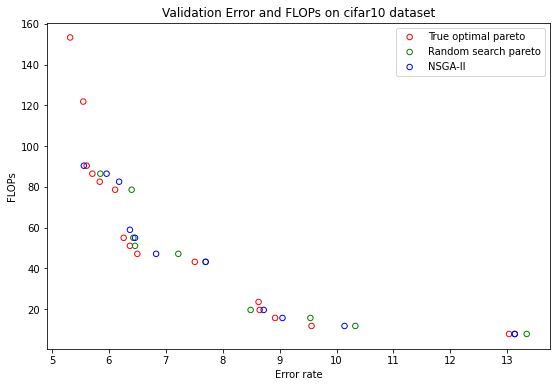

In [116]:
experimenting(pop_size = 20, n_gen = 20, crossover = 'bin_one_point',
              dataset = 'cifar10', n_random = 400)

### Results on CIFAR100 dataset

NSGA-II is searching...
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      20 |       7 |            - |            -
    2 |      40 |      10 |  0.173501581 |        nadir
    3 |      60 |      10 |  0.451908388 |        nadir
    4 |      80 |      10 |  0.149232911 |        ideal
    5 |     100 |       9 |  0.004201681 |        nadir
    6 |     120 |       9 |  0.013227512 |            f
    7 |     140 |       9 |  0.008684642 |            f
    8 |     160 |      10 |  0.009812594 |            f
    9 |     180 |       9 |  0.007046202 |            f
   10 |     200 |      12 |  0.014766612 |            f
   11 |     220 |       9 |  0.022295555 |            f
   12 |     240 |       9 |  0.024590162 |        ideal
   13 |     260 |       9 |  0.00000E+00 |            f
   14 |     280 |       9 |  0.00000E+00 |            f
   15 |     300 |      10 |  0.003697240 |            f
   16 |     320 |      11 |  0.040629095 |        ideal
   17 |     340 |      1

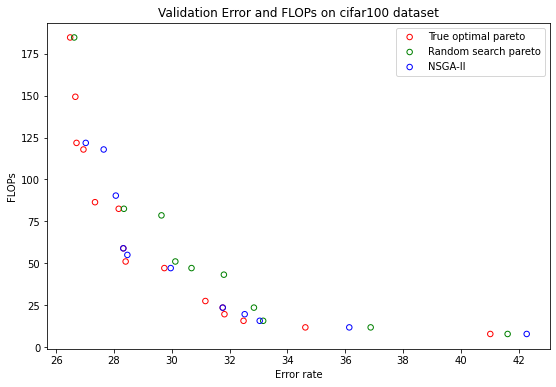

In [117]:
experimenting(pop_size = 20, n_gen = 20, crossover = 'bin_one_point',
              dataset = 'cifar100', n_random = 400)

### Results on ImageNet16-120 dataset

NSGA-II is searching...
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      19 |       5 |            - |            -
    2 |      39 |       7 |  0.021113246 |        ideal
    3 |      59 |       8 |  0.013257575 |        ideal
    4 |      79 |       9 |  0.011235949 |        ideal
    5 |      99 |       9 |  0.030853000 |        ideal
    6 |     119 |       9 |  0.019572949 |        ideal
    7 |     139 |       9 |  0.000395413 |            f
    8 |     159 |       8 |  0.028169017 |        ideal
    9 |     179 |       8 |  0.050000000 |        nadir
   10 |     199 |       9 |  0.006731167 |            f
   11 |     219 |       9 |  0.092307691 |        nadir
   12 |     239 |      10 |  0.006323509 |            f
   13 |     259 |      10 |  0.004376364 |        ideal
   14 |     279 |      10 |  0.004376367 |            f
   15 |     299 |      11 |  0.049896057 |        ideal
   16 |     319 |      11 |  0.000945001 |            f
   17 |     339 |      1

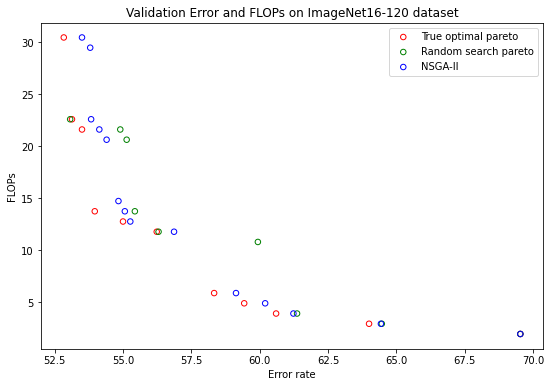

In [118]:
experimenting(pop_size = 20, n_gen = 20, crossover = 'bin_one_point',
              dataset = 'ImageNet16-120', n_random = 400)

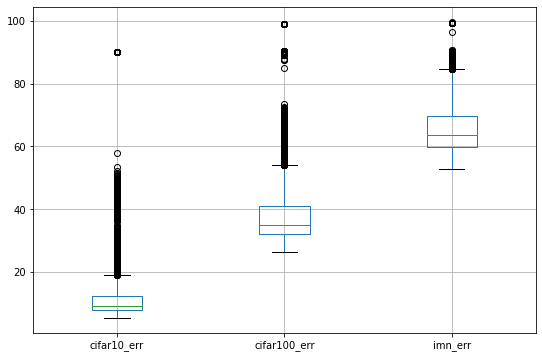

In [112]:
import pandas as pd
df = pd.DataFrame([], columns = ['cifar10_err', 'cifar100_err', 'imn_err'])
df['cifar10_err'] = cf10_objs[:, 0]
df['cifar100_err'] = cf100_objs[:,0]
df['imn_err'] = imn_objs[:,0]

plt.figure(figsize = (9, 6) )
df.boxplot()


In [114]:
# TODO: extract network id from the searching process and infer the test acc of pareto founded by each methods